In [1]:
import os
import logging
from pathlib import Path

import scanpy as sc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import wandb
from einops import rearrange
from pytorch_lightning.loggers import WandbLogger

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
from mushroom.models.expression_prediction import STExpressionLightning
from mushroom.learners import HEExpressionPredictor, STExpressionLearner

## load data

In [6]:
genes = [
    'IL7R',
    'PTPRC',
    'ACTA2',
    'BGN',
    'EPCAM',
    'MS4A1',
    'PECAM1',
]

In [7]:
def adata_from_visium(fp):
    sid = fp.split('/')[-1]
    a = sc.read_visium(fp)
    a.var_names_make_unique()
    a = a[:, genes]
    a.obsm['spatial'] = a.obsm['spatial'].astype(int)
    return a

In [8]:
# train_ids = ['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4']
# val_ids = ['BR_206B1_U5']
# fps = [
#     '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2',
#     '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3',
#     '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U4',
#     '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U5',
# ]
# sid_to_adata = {fp.split('/')[-1]:adata_from_visium(fp) for fp in fps}

# fps = {
#     'BR_206B1_U2': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif',
#     'BR_206B1_U3': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif',
#     'BR_206B1_U4': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U4.tif',
#     'BR_206B1_U5': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U5.tif',
# }

# sid_to_he = {sid:tifffile.imread(fp) for sid, fp in fps.items()}
# sid_to_he.keys()

In [9]:
train_ids = ['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21']
val_ids = ['HT397B1-S1H3A1U21']
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21',
]
sid_to_adata = {fp.split('/')[-1]:adata_from_visium(fp) for fp in fps}

fps = {
    'HT397B1-S1H3A1U1':  '/data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif',
    'HT397B1-S1H3A1U21': '/data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif',
}

sid_to_he = {sid:tifffile.imread(fp) for sid, fp in fps.items()}
sid_to_he.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21'])

In [10]:
project = 'expression_model'
run_dir = '/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1'
log_dir = os.path.join(run_dir, 'logs')
chkpt_dir = os.path.join(run_dir, 'chkpts')
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [11]:
a = next(iter(sid_to_adata.values()))
a

AnnData object with n_obs × n_vars = 3058 × 7
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [12]:
train_adatas = {sid:sid_to_adata[sid] for sid in train_ids}
val_adatas = {sid:sid_to_adata[sid] for sid in val_ids}

train_hes = {sid:sid_to_he[sid] for sid in train_ids}
val_hes = {sid:sid_to_he[sid] for sid in val_ids}

In [13]:
# config = {
#     'size': (64, 64),
#     'context_res': 2,
#     'scale': 1.,
#     'max_voxels': 32,
#     'training': {
#         'max_epochs': 10,
#         'log_every': 1,
#         'chkpt_every': 5,
#         'limit_train_batches': 1.,
#         'limit_val_batches': .1,
#         'accelerator': 'gpu',
#         'devices': [0],
#         'lr': 2e-5,
#     },
# }

In [13]:
config = {
    'training': {
        'max_epochs': 50,
        'log_every': 1,
        'chkpt_every': 5,
        'limit_train_batches': 1.,
        'limit_val_batches': .1,
        'accelerator': 'gpu',
        'devices': [1],
        'lr': 2e-5,
    },
}

In [14]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [15]:
# wandb.finish()

In [16]:
# learner = STExpressionLearner(train_adatas, val_adatas, config, logger=logger, num_workers=20)
learner = STExpressionLearner(train_adatas, val_adatas, config,
                              train_hes=train_hes, val_hes=val_hes,
                              logger=logger, num_workers=30)

{'backbone': 'resnet34', 'genes': None, 'n_metagenes': 10, 'he_scaler': 0.1, 'kl_scaler': 0.001, 'exp_scaler': 1.0, 'size': (128, 128), 'context_res': 2, 'scale': 0.2, 'max_voxels': 64, 'means': (0.74600196, 0.67650163, 0.8227606), 'stds': (0.20359719, 0.2339519, 0.13040961), 'training': {'log_n_samples': 8, 'max_epochs': 50, 'log_every': 1, 'chkpt_every': 5, 'limit_train_batches': 1.0, 'limit_val_batches': 0.1, 'accelerator': 'gpu', 'devices': [1], 'lr': 2e-05, 'precision': 32}}


In [42]:
# ds = next(iter(learner.sid_to_train_ds.values()))
# for i in range(100):
#     d = ds[i]

keys: dict_keys(['he', 'labeled_img', 'context_he', 'context_labeled_img', 'voxel_idxs', 'masks', 'exp', 'n_voxels'])


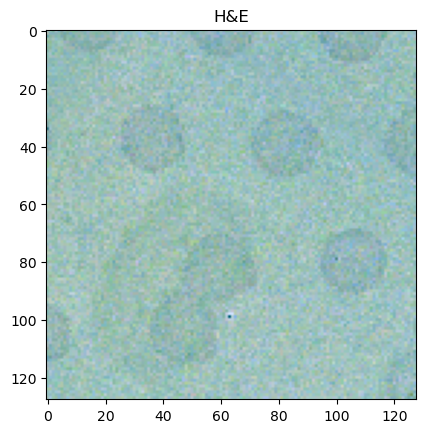

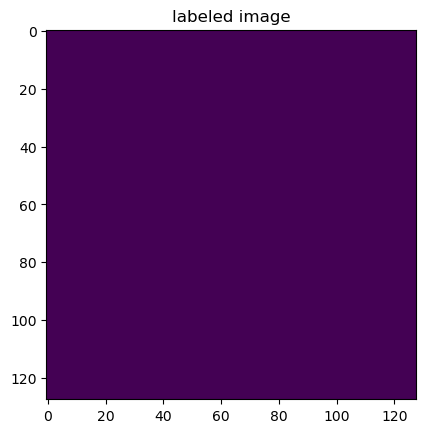

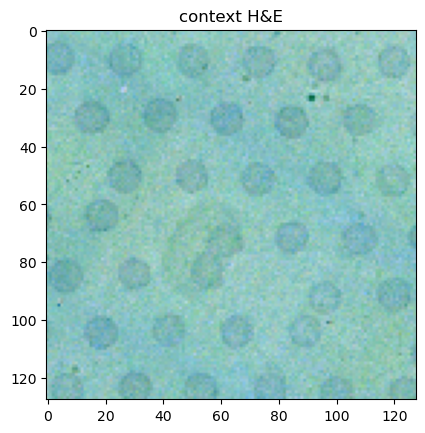

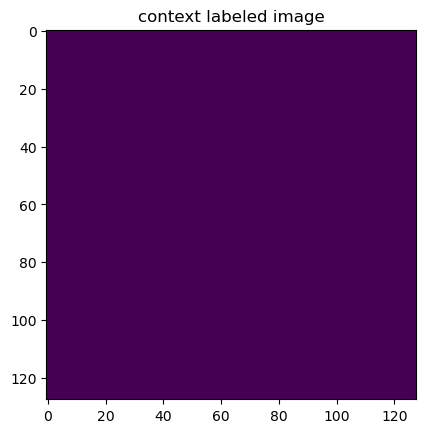

voxel idxs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labeled image voxel idxs: tensor([0], dtype=torch.int32)
masks shape: torch.Size([64, 128, 128])


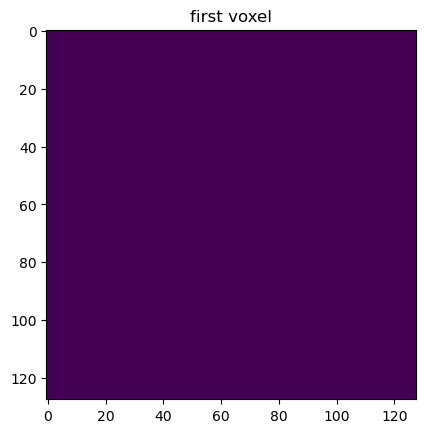

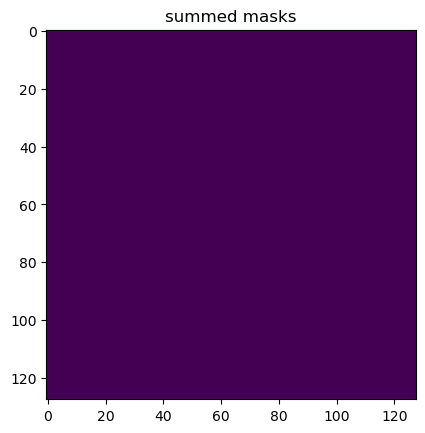

expression counts shape: torch.Size([64, 7])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
     

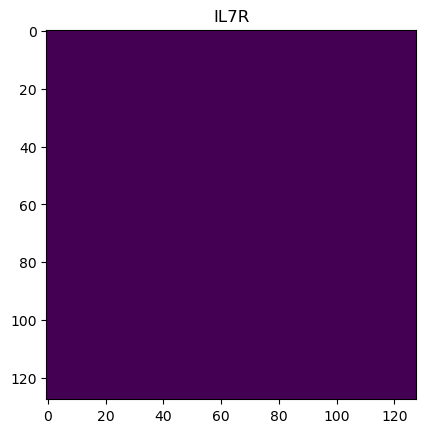

In [43]:
next(iter(learner.sid_to_train_ds.values())).sanity_check()

In [44]:
learner.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/logs/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params
--------------------------------------------
0 | model | STExpressionModel | 45.2 M
--------------------------------------------
45.2 M    Trainable params
0         Non-trainable params
45.2 M    Total params
180.604   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/data/estorrs/mushroom/mushroom/utils.py:100: RuntimeWarning: invalid value encountered in divide
  tile /= np.expand_dims(tile.max(axis=(0, -2, -1)), (0, -2, -1))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
learner.trainer.save_checkpoint(os.path.join(log_dir, "ckpts", 'model.pt'))

In [48]:
sorted(utils.listfiles(os.path.join(log_dir, "ckpts")))

['/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/logs/ckpts/epoch=49-step=17200.ckpt',
 '/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/logs/ckpts/model.pt']

In [17]:
model = STExpressionLightning.load_from_checkpoint(os.path.join(log_dir, "ckpts", 'model.pt'))

In [18]:
predictor = HEExpressionPredictor(model)

genes = None
sid_to_exp = {}
for sid, a in sid_to_adata.items():
    he = a.uns['trimmed']
    img, genes = predictor.predict(he)
    sid_to_exp[sid] = img
sid_to_exp.keys()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21'])

In [19]:
genes

['IL7R', 'PTPRC', 'ACTA2', 'BGN', 'EPCAM', 'MS4A1', 'PECAM1']

In [21]:
import torchvision.transforms.functional as TF
import torch
cuts = {
    'IL7R': .9,
    'EPCAM': .94,
    'ACTA2': .89
}
# cuts = {
#     'HT397B1-S1H3A1U1': {
#         'IL7R': .9,
#         'EPCAM': .94,
#         'ACTA2': .89   
#     },
#     'HT397B1-S1H3A1U21': {
#         'IL7R': .9,
#         'EPCAM': .94,
#         'ACTA2': .89   
#     },
# }
sid_to_masks = {}
for sid, img in sid_to_exp.items():
    subsampled = TF.resize(img, (int(img.shape[-2] * .1), int(img.shape[-1] * .1))).to(torch.float32)
    subsampled = TF.gaussian_blur(subsampled, 43)
    subsampled -= rearrange(rearrange(subsampled, 'c h w -> c (h w)').min(dim=1).values, 'b -> b 1 1')
    subsampled /= rearrange(rearrange(subsampled, 'c h w -> c (h w)').max(dim=1).values, 'b -> b 1 1')
    
    new = torch.zeros((len(cuts), subsampled.shape[1], subsampled.shape[2]), dtype=torch.bool)
    for i, (gene, val) in enumerate(cuts.items()):
        gene_idx = genes.index(gene)
        new[i] = subsampled[gene_idx] > val
    
    sid_to_masks[sid] = new
        
        

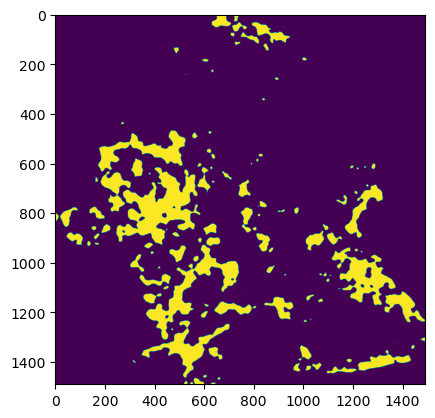

In [22]:
plt.imshow(next(iter(sid_to_masks.values()))[0])

In [23]:
np.asarray(list(cuts.keys()))

array(['IL7R', 'EPCAM', 'ACTA2'], dtype='<U5')

In [25]:
out_dir = os.path.join(run_dir, 'predictions')
Path(out_dir).mkdir(parents=True, exist_ok=True)

for sid, masks in sid_to_masks.items():
    d = {
        'masks': masks,
        'genes': list(cuts.keys()),
        'cuts': list(cuts.values())
    }
    torch.save(d, os.path.join(out_dir, f'{sid}_masks.pt'))
    
    d = {
        'expression': sid_to_exp[sid],
        'genes': genes
    }
    torch.save(d, os.path.join(out_dir, f'{sid}_expression.pt'))

HT397B1-S1H3A1U1


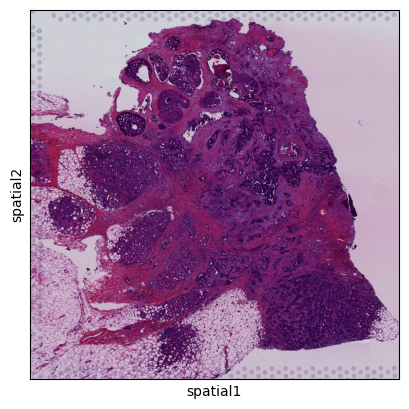

HT397B1-S1H3A1U21


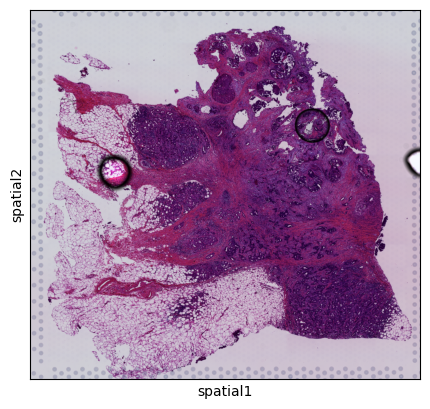

In [27]:
for sid, a in sid_to_adata.items():
    print(sid)
    sc.pl.spatial(a)
    plt.show()

HT397B1-S1H3A1U1


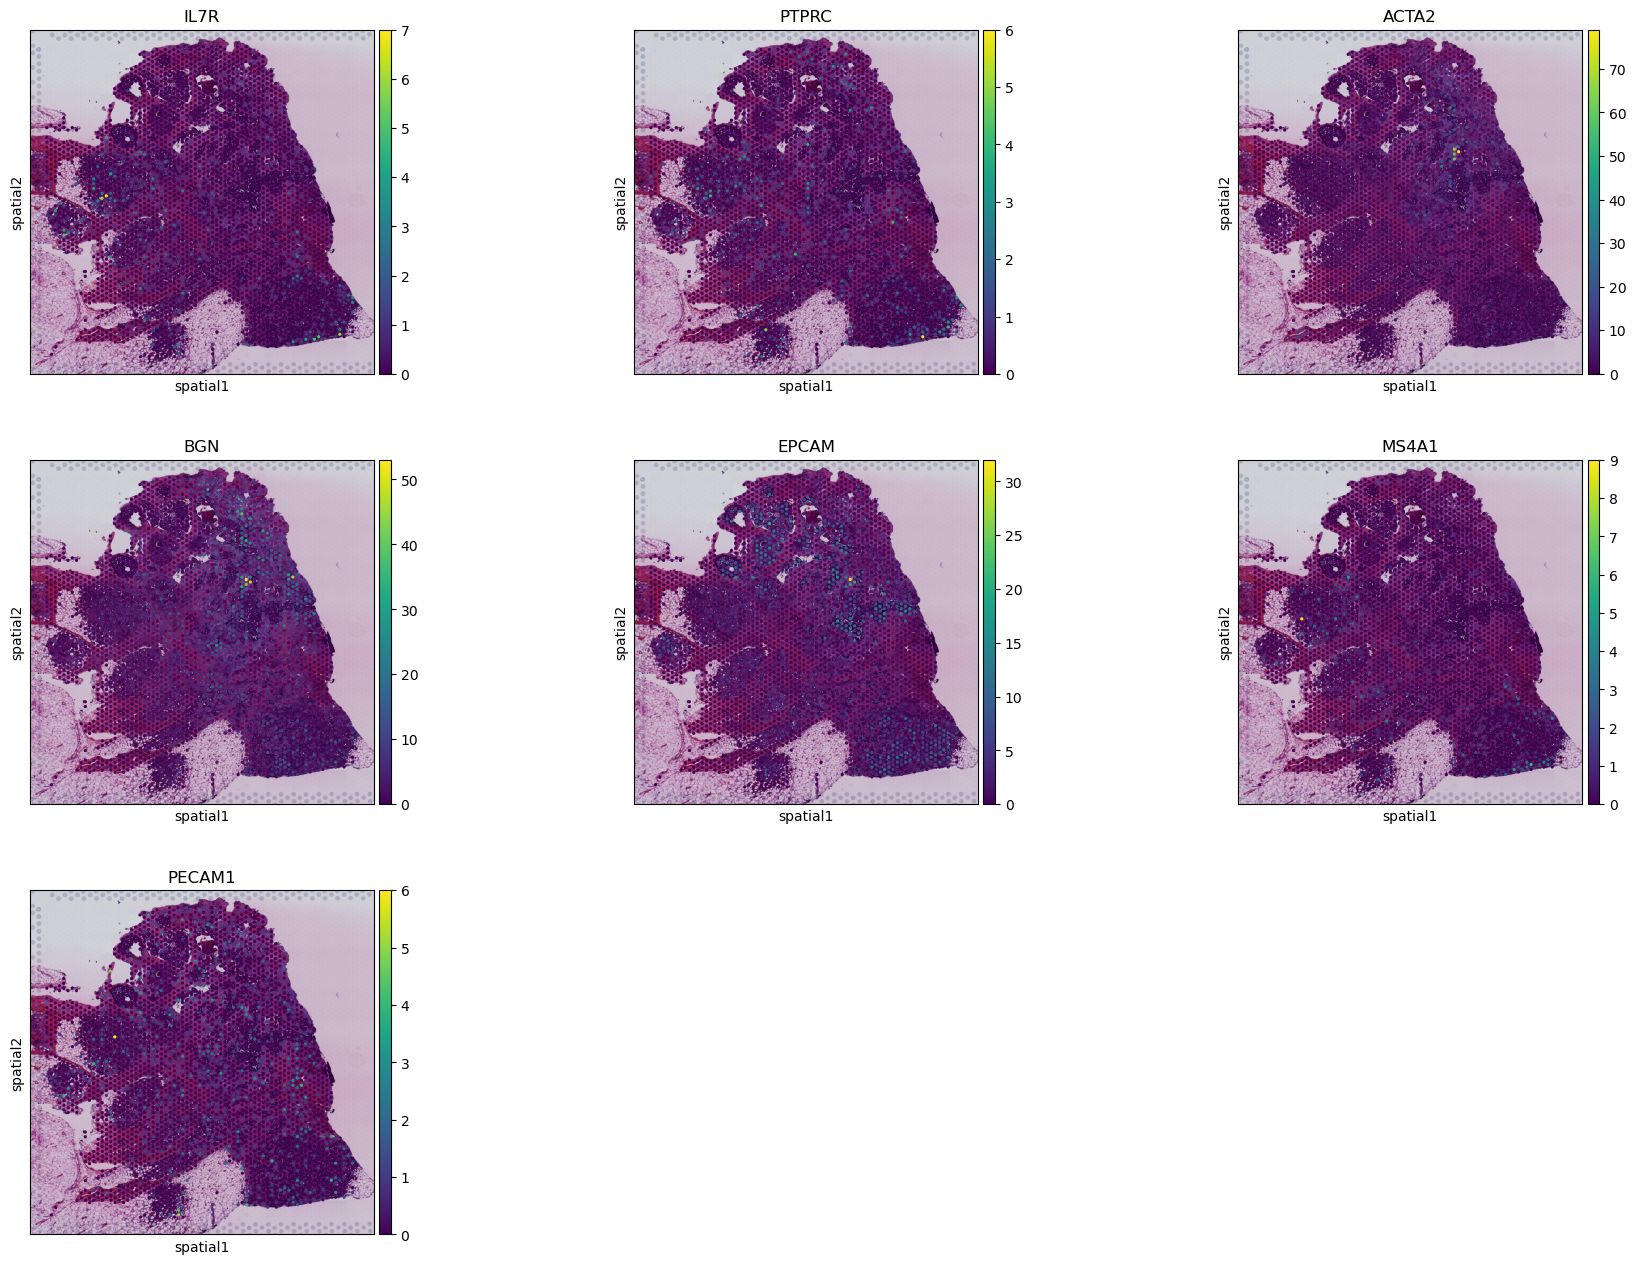

HT397B1-S1H3A1U21


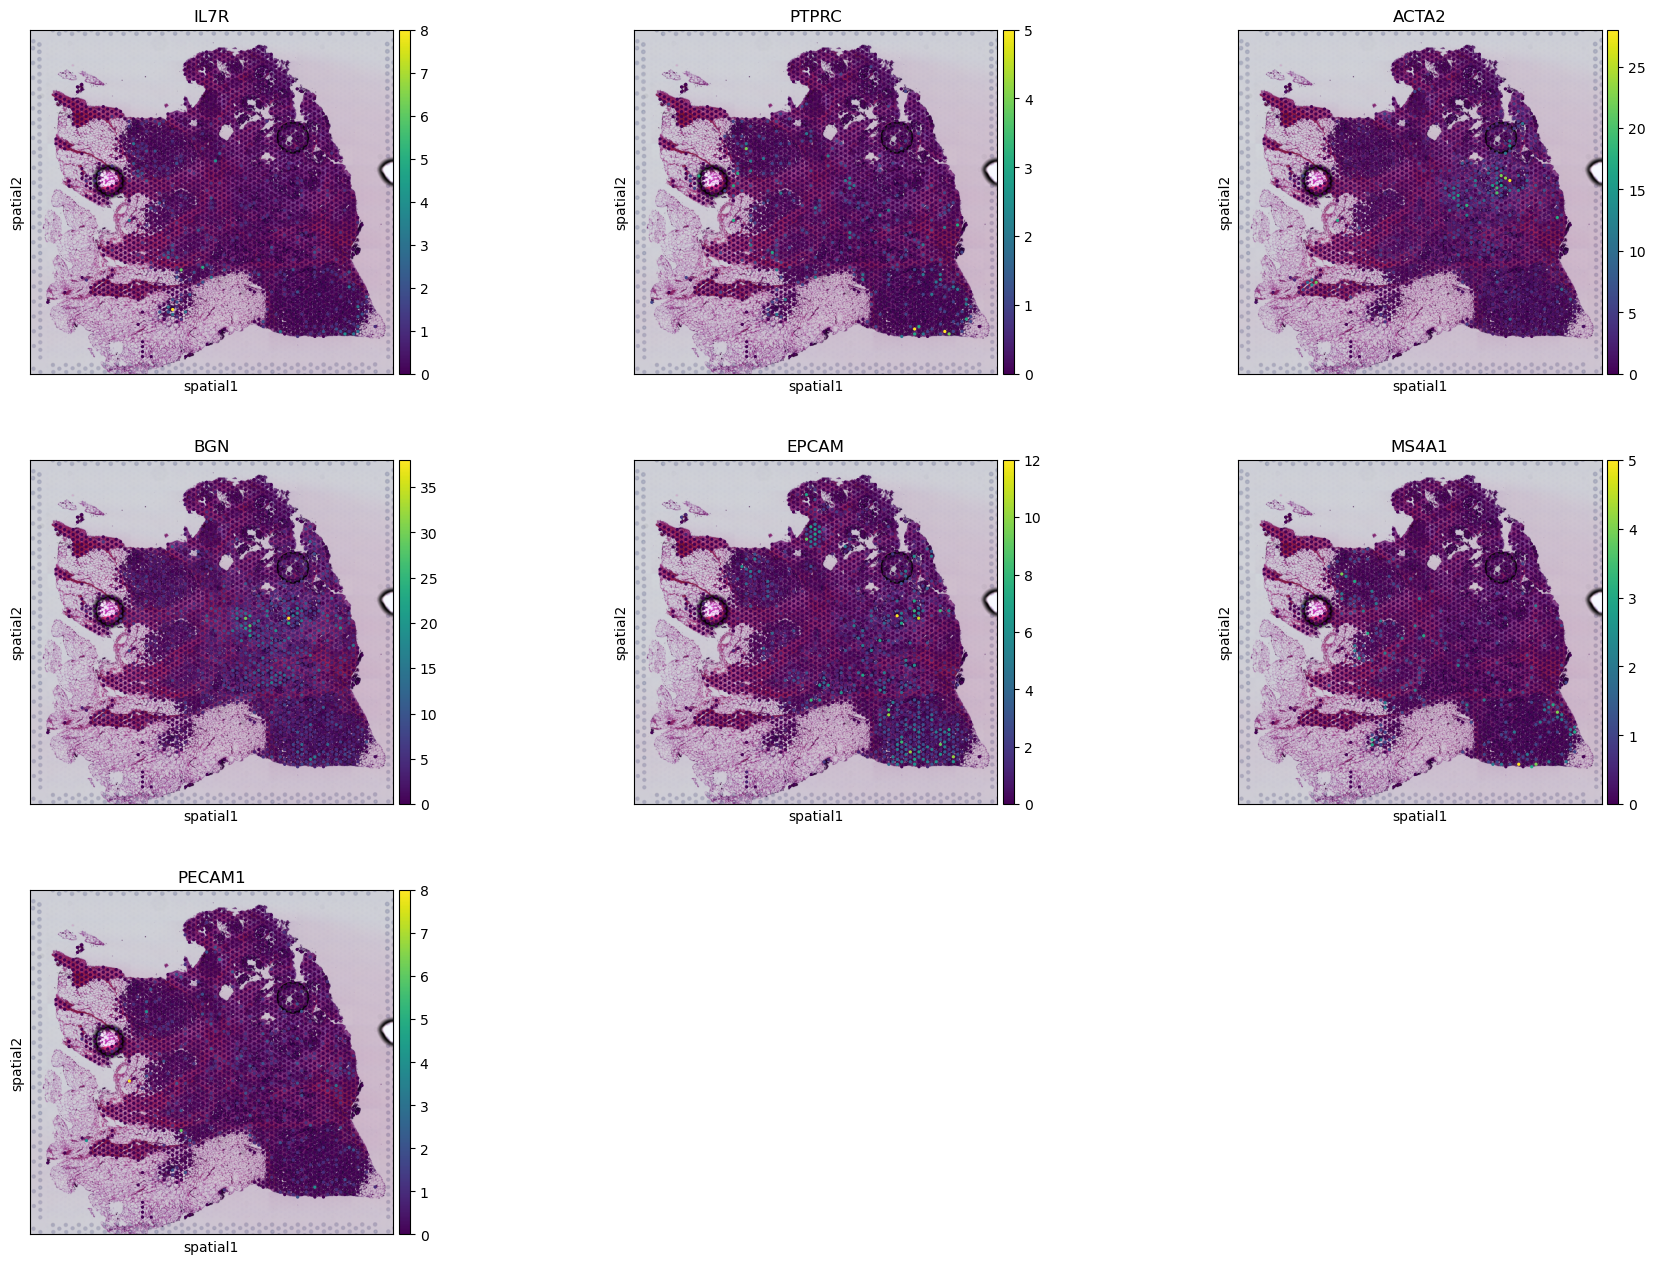

In [28]:
for sid, a in sid_to_adata.items():
    print(sid)
    sc.pl.spatial(a, color=genes, ncols=3)
    plt.show()

###### set thresholds

In [31]:
# sid = next(iter(sid_to_adata.keys()))
sid = 'HT397B1-S1H3A1U21'

In [32]:
img = sid_to_exp[sid]

In [33]:
import torchvision.transforms.functional as TF
import torch

subsampled = TF.resize(img, (int(img.shape[-2] * .1), int(img.shape[-1] * .1))).to(torch.float32)
subsampled = TF.gaussian_blur(subsampled, 43)
subsampled -= rearrange(rearrange(subsampled, 'c h w -> c (h w)').min(dim=1).values, 'b -> b 1 1')
subsampled /= rearrange(rearrange(subsampled, 'c h w -> c (h w)').max(dim=1).values, 'b -> b 1 1')

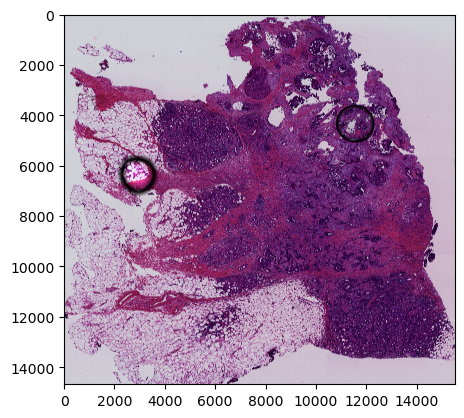

In [34]:
plt.imshow(sid_to_adata[sid].uns['trimmed'])

In [35]:
subsampled[genes.index('BGN')]

tensor([[0.7685, 0.7681, 0.7669,  ..., 0.7375, 0.7362, 0.7358],
        [0.7674, 0.7670, 0.7658,  ..., 0.7365, 0.7352, 0.7347],
        [0.7644, 0.7640, 0.7628,  ..., 0.7336, 0.7323, 0.7318],
        ...,
        [0.6562, 0.6559, 0.6549,  ..., 0.6346, 0.6338, 0.6336],
        [0.6562, 0.6560, 0.6550,  ..., 0.6344, 0.6337, 0.6335],
        [0.6563, 0.6560, 0.6551,  ..., 0.6344, 0.6337, 0.6335]])

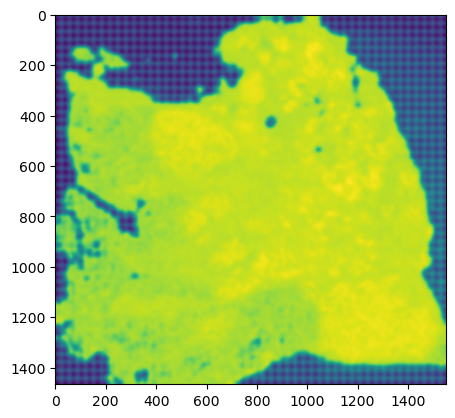

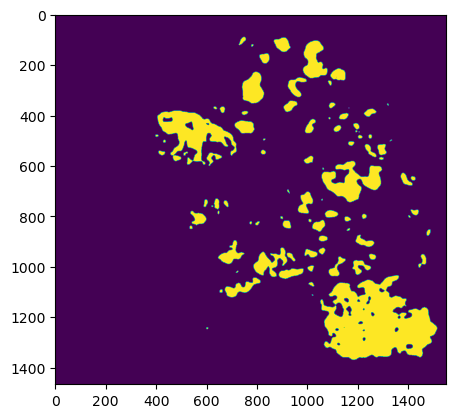

In [36]:
gene = 'EPCAM'
gene_idx = genes.index(gene)
cut = .94
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()

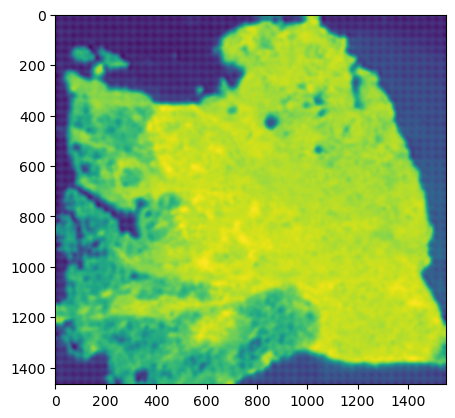

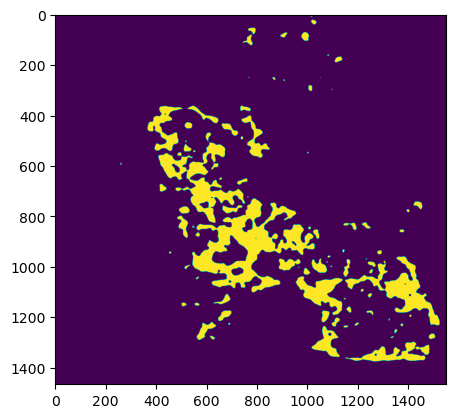

In [40]:
gene = 'IL7R'
gene_idx = genes.index(gene)
cut = .92
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()

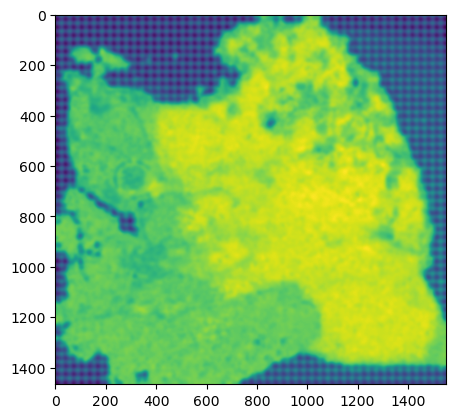

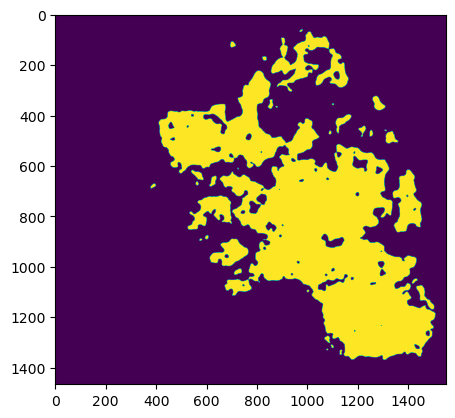

In [38]:
gene = 'ACTA2'
gene_idx = genes.index(gene)
cut = .89
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()